In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import models


1.13.1


In [9]:
!pip install SimpleITK
import SimpleITK as sitk 
%cd '/content/gdrive/My Drive/DeepLearning/2DUNet'
from preProcess import data_preprocess_test
from preProcess import swapLabelsBack
from utils import getTrainNLabelNames


/content/gdrive/My Drive/DeepLearning/2DUNet


In [6]:
modality = ["mr"]
data_folder = '/content/gdrive/My Drive/ImageData/MMWHS'
x_train_filenames, y_train_filenames = getTrainNLabelNames(data_folder, modality[0])
print("Number of training volumes %d" % len(x_train_filenames))
print("Number of mask volumes %d" % len(y_train_filenames))

Number of training volumes 20
Number of mask volumes 20


#Load model

In [0]:
from loss import bce_dice_loss, dice_loss, la_loss
save_model_path = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs/weights_multi-all2.hdf5'
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss, 'la_loss': la_loss})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


#Visualization

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(363, 256, 256)
(200, 256, 256)


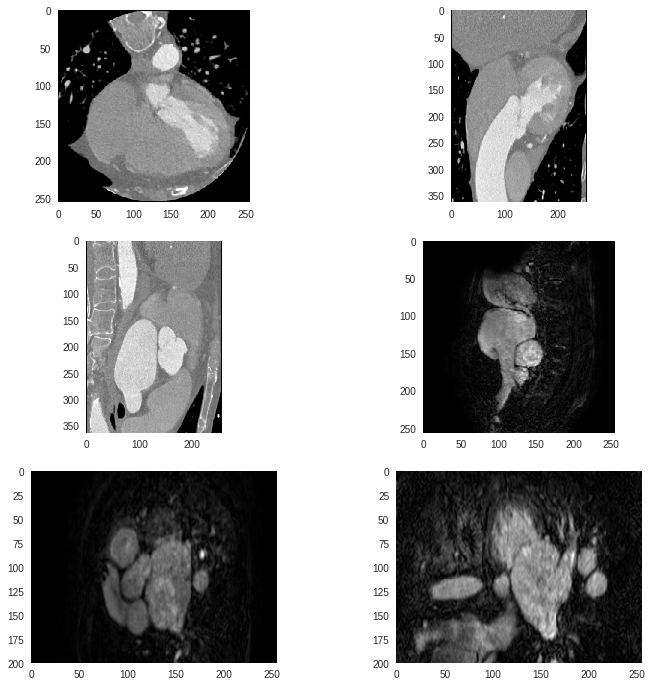

In [29]:
ct_path = '/content/gdrive/My Drive/ImageData/MMWHS/ct_train/ct_train_1001_image.nii.gz'
mr_path = '/content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1015_image.nii.gz'
im_vol_ct,_ = data_preprocess_test(ct_path, 0, 256, "ct")
im_vol_mr,_ = data_preprocess_test(mr_path, 0, 256, "mr")
print(im_vol_ct.shape)
print(im_vol_mr.shape)

#mr views: 0-sagital 1-axial 2-coronal
#ct views: 0-axial 2-coronal 2-sagital
plt.figure()
plt.subplot(3,2,1)
plt.imshow(im_vol_ct[150,:,:],cmap='gist_gray')
plt.subplot(3,2,2)
plt.imshow(im_vol_ct[:,150,:],cmap='gist_gray')
plt.subplot(3,2,3)
plt.imshow(im_vol_ct[:,:,120],cmap='gist_gray')
plt.subplot(3,2,4)
plt.imshow(im_vol_mr[150,:,:],cmap='gist_gray')
plt.subplot(3,2,5)
plt.imshow(im_vol_mr[:,150,:],cmap='gist_gray')
plt.subplot(3,2,6)
plt.imshow(im_vol_mr[:,:,150],cmap='gist_gray')

plt.show()

#Prediction

In [0]:
from preProcess import RescaleIntensity
def data_preprocess_test(image_vol_fn, view, size, m):
    img = sitk.ReadImage(image_vol_fn)
    image_vol = sitk.GetArrayFromImage(img)
    ori = img.GetOrigin()
    space = img.GetSpacing()
    direc = img.GetDirection()
    
    original_shape = image_vol.shape
    image_vol = RescaleIntensity(image_vol, m)
    shape = [size, size, size]
    shape[view] = image_vol.shape[view]
    image_vol_resize = resize(image_vol, tuple(shape))
    
    image_info = (ori, space, direc)
    
    return image_vol_resize, original_shape, image_info

In [0]:
from skimage.transform import resize
def predictVol(image_vol_fn, label_fn, modality, save_fn=None):
    im_vol, ori_shape, info = data_preprocess_test(image_vol_fn, 0, 256, modality)
    predicted_label = np.argmax(model.predict(np.expand_dims(im_vol,axis=-1)),axis=-1)
    print(predicted_label.shape)
    print(ori_shape)
    print(np.unique(predicted_label))
    predicted_label = resize(predicted_label.astype(np.float), ori_shape, order=0)
    
    labels = sitk.GetArrayFromImage(sitk.ReadImage(label_fn))
    print(labels.shape)
    print(predicted_label.shape)
    labels[labels==421]=420
    predicted_label = swapLabelsBack(labels,predicted_label)
    if save_fn:
      ori, space, direc = info
      out_im = sitk.GetImageFromArray(predicted_label)
      out_im.SetOrigin(ori)
      out_im.SetSpacing(space)
      out_im.SetDirection(direc)
      
      sitk.WriteImage(out_im, save_fn)
    return predicted_label, labels

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(160, 256, 256)
(160, 512, 512)
[0 1 2 3 4 5 6 7]
(160, 512, 512)
(160, 512, 512)


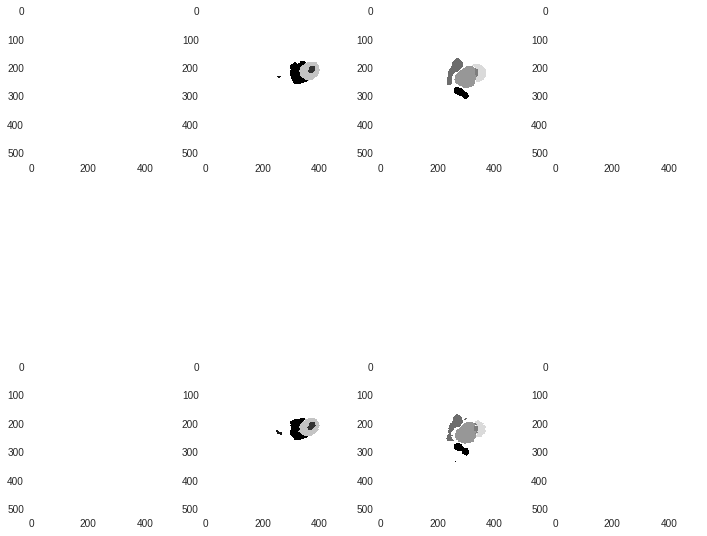

In [0]:
test_fn = '/content/gdrive/My Drive/DeepLearning/2DUNet/test.nii.gz'
predicted_label, labels = predictVol(x_train_filenames[0],y_train_filenames[0],modality[0], test_fn)
plt.figure()
plt.subplot(2,4,1)
plt.imshow(predicted_label[20,:,:])
plt.subplot(2,4,5)
plt.imshow(labels[20,:,:])

plt.subplot(2,4,2)
plt.imshow(predicted_label[40,:,:])
plt.subplot(2,4,6)
plt.imshow(labels[40,:,:])

plt.subplot(2,4,3)
plt.imshow(predicted_label[80,:,:])
plt.subplot(2,4,7)
plt.imshow(labels[80,:,:])

plt.subplot(2,4,4)
plt.imshow(predicted_label[120,:,:])
plt.subplot(2,4,8)
plt.imshow(labels[120,:,:])

#Compute Dice Scores

In [0]:
from scipy.spatial.distance import dice
def dice_score(pred, true):
  #true = sitk.GetArrayFromImage(sitk.ReadImage(true_fn))
  pred = pred.astype(np.int)
  true = true.astype(np.int)  
  num_class = np.unique(true)
  dice_out = [None]*len(num_class)
  
  for i in range(len(num_class)):
    pred_i = pred==num_class[i]
    true_i = true==num_class[i]
    sim = 1 - dice(pred_i.reshape(-1), true_i.reshape(-1))
    dice_out[i] = sim
    
  return dice_out
    
    

In [0]:
test_fn = '/content/gdrive/My Drive/DeepLearning/2DUNet/test.nii.gz'
_, _ = predictVol(x_train_filenames[0],y_train_filenames[0],modality[0],test_fn)
import csv
with open('/content/gdrive/My Drive/DeepLearning/2DUNet/dice_mr.csv', 'w') as writeFile:
  writer = csv.writer(writeFile)
  writer.writerow( ('Bg 0', 'myo 205', 'la 420', 'lv 500', 'ra 550', 'rv 600', 'aa 820', 'pa 850') )
  for i in range(20):
    print("processing image volume %s" % x_train_filenames[i])
    predicted_label, labels = predictVol(x_train_filenames[i],y_train_filenames[i],modality[0])
    dice_out = dice_score(predicted_label, labels)
    writer.writerow(tuple(dice_out))
    print(dice_out)
  
writeFile.close()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0 1 2 3 4 5 6 7]
processing image volume /content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1001_image.nii.gz
[0 1 2 3 4 5 6 7]
[0.9991314551679532, 0.931838454254779, 0.9426203968763996, 0.9148275298348864, 0.9119008036933893, 0.876436741574599, 0.9380082363544919, 0.9102966286780765]
processing image volume /content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1002_image.nii.gz
[0 1 2 3 4 5 6 7]
[0.9989529400181817, 0.9126903211128993, 0.948471201227886, 0.9268995843009923, 0.946947825922159, 0.9247253627310736, 0.9302353790263399, 0.9281368274804772]
processing image volume /content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1003_image.nii.gz
[0 1 2 3 4 5 6 7]
[0.9974417410798122, 0.9008631319358816, 0.9042630017665293, 0.9608130305961099, 0.9442265603196287, 0.953628259263303, 0.9480332182267222, 0.9366661231380147]
processing image volume /content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1004_image.nii.gz
[0 1 2 3 4 5 6 7]
[0.9979551813570798, 0.92061

In [0]:
data_out_folder = '/content/gdrive/My Drive/DeepLearning/2DUNet/test_masks'
modality = ["mr", "ct"]
for m in modality:
  for subject_dir in sorted(glob.glob(os.path.join(data_folder,m+'_test','*.nii.gz'))):
      in_filename = os.path.realpath(subject_dir)
      out_filename = os.path.join(data_out_folder, os.path.basename(subject_dir))
      _,_ = predictVol(in_filename,y_train_filenames[0],m, out_filename)
      print(in_filename,out_filename)
      

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(140, 256, 256)
(140, 288, 288)
[0 1 2 3 4 5 6 7]
(160, 512, 512)
(140, 288, 288)
/content/gdrive/My Drive/ImageData/MMWHS/mr_test/mr_test_2001_image.nii.gz /content/gdrive/My Drive/DeepLearning/2DUNet/test_masks/mr_test_2001_image.nii.gz
(150, 256, 256)
(150, 288, 288)
[0 1 2 3 4 5 6 7]
(160, 512, 512)
(150, 288, 288)
/content/gdrive/My Drive/ImageData/MMWHS/mr_test/mr_test_2002_image.nii.gz /content/gdrive/My Drive/DeepLearning/2DUNet/test_masks/mr_test_2002_image.nii.gz
(140, 256, 256)
(140, 256, 256)
[0 1 2 3 4 5 6 7]
(160, 512, 512)
(140, 256, 256)
/content/gdrive/My Drive/ImageData/MMWHS/mr_test/mr_test_2003_image.nii.gz /content/gdrive/My Drive/DeepLearning/2DUNet/test_masks/mr_test_2003_image.nii.gz
(130, 256, 256)
(130, 288, 288)
[0 1 2 3 4 5 6 7]
(160, 512, 512)
(130, 288, 288)
/content/gdrive/My Drive/ImageData/MMWHS/mr_test/mr_test_2004_image.nii.gz /content/gdrive/My Drive/DeepLearning/2DUNet/test_masks/mr_test_2004_image.nii.gz
(135, 256, 256)
(135, 320, 320)
[0 1 2 3 4 5